# This notebook simulates a simple mountain destroyed by rainfall and glaciers


figured out that scipy zoom really makes the figures shine


## Principles:

* The land starts as rock

* Rain falls on a random set of figures at every step

* Rain flows downhill, and can barely scratch the rock, but drags the gravel along

* The temperature is determined by height

* Rain freezes to glacier if it's below zero

* Glaciers destroy the rock into gravel below them

* Glaciers flow downhill slowly

* When above zero, a glacier melts at a constant rate


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl

import scipy.signal as signal
import scipy.ndimage as ndimage
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

# Making a mountainside

In [10]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel

def triangle(dists, scale=50):
    """triangle kernel, scale is when it hits zero"""
    kernel = np.zeros(dists.shape)
    kernel = scale - dists
    kernel[kernel < 0] = 0
    kernel = kernel / kernel.sum()
    return kernel

kernels = {
    "gauss": gaussian,
    "tophat": tophat,
    "triangle": triangle,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp

def convolve_map(canvas, scale, which = "gauss",):
    pad_width = scale*3
    padded = np.pad(canvas, pad_width = scale*3)
    half_extent = scale*2
    dists = distance_kernel(half_extent = half_extent)    
    kern = kernels[which](dists, scale = scale)
    
    # There's some shape difference here, which needs to be manually corrected with the padding
    # just offset the convolved image by the half_extent of the kernel...
    tmp = np.fft.irfft2(np.fft.rfft2(padded) * np.fft.rfft2(kern, padded.shape))
    tmp = tmp[pad_width+half_extent:-pad_width+half_extent, pad_width+half_extent:-pad_width+half_extent]
    return tmp

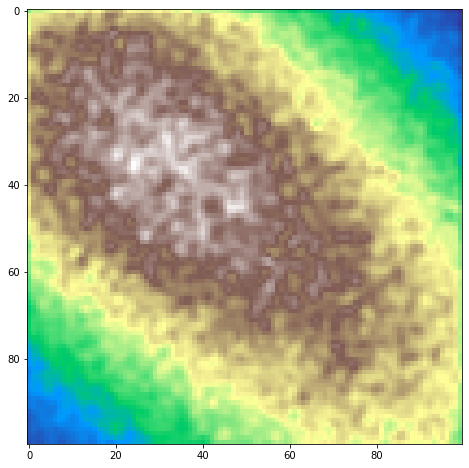

In [18]:
samples1 = np.random.multivariate_normal((1.7, 1.8), cov=np.eye(2), size=int(2e6))
samples2 = np.random.multivariate_normal((0.4, 0.3), cov=np.eye(2), size=int(2.4e6))
# samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2)*1, size=1800000)
# samples3 = np.random.multivariate_normal((4.5, 1.8), cov=np.eye(2), size=1100000)
# samples4 = np.random.multivariate_normal((7, 3), cov=np.eye(2)*1.5, size=2000000)
samples = np.concatenate((samples1, samples2))

bins = np.linspace(0, 2, 104)

bcens = bins[:-1] + np.diff(bins) / 2
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins), density=True)[0] * 4
land = convolve_map(land, 1, which="gauss")
land = land[1:-2, 1:-1]

lmax = land.max()
land = (land / lmax)**2. * lmax
land *= 5000

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain)

In [19]:
zland = ndimage.zoom(land, 4)

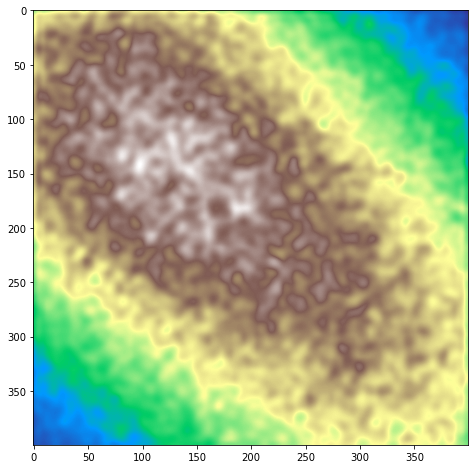

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(zland, cmap=plt.cm.terrain)

In [23]:
land.min()

686.8695520450817

# Erosion model of the mountain side

In [13]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [108]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    def _calc_flows(self, vmap, outflow, cell):
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        return shifted_landslide.sum(axis=0)
    
    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        vmap += self._calc_flows(vmap, outflow, cell)
        return vmap
         
        
class RainFall(FlowRule):
    def __init__(self, rainfall=1, fraction=0.2, seed=10):
        """
        This is adds new rain water to the water canvas
    
        """
        self.layers = np.sort(("water",))
        self.key = "water"
        self.rainfall = rainfall
        self.fraction = fraction
        self.rng = np.random.RandomState(seed)
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        rmax = 10
        rpiv = rmax * (1 - self.fraction)
        rainmap = np.random.randint(0, rmax, size=water_local.shape)
        rainmap[rainmap <= rpiv] = 0.
        rainmap[rainmap > rpiv] = self.rainfall
        
        water_local += rainmap
        
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        


In [107]:
rainmap

array([[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
waqt

In [62]:
water.sum()

10000.0

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [53]:
water.sum()

10000.0

In [30]:
len(zland.flatten())

160000